In [14]:
import numpy as np
import pytreenet as ptn
from copy import deepcopy

In [3]:
shapes = {
    (0, 0): (2, 2, 2),
    (0, 1): (2, 2, 2, 2),
    (0, 2): (2, 2, 2, 2),
    (0, 3): (2, 2, 2),
    (1, 0): (2, 2),
    (1, 1): (2, 2),
    (1, 2): (2, 2),
    (1, 3): (2, 2, 2),
    (2, 0): (2, 2),
    (2, 1): (2, 2),
    (2, 2): (2, 2),
    (2, 3): (2, 2, 2, 2),
    (3, 0): (2, 2, 2),
    (3, 1): (2, 2, 2, 2),
    (3, 2): (2, 2, 2),
    (3, 3): (2, 2, 2)
}

nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(nodes[(0, 0)][0], nodes[(0, 0)][1])

connections = [
    ((0, 0), (1, 0), 0, 0),
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (1, 1), 1, 0),   
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((0, 2), (0, 3), 2, 0),   
    ((0, 3), (1, 3), 1, 0),
    ((1, 3), (2, 3), 1, 0),
    ((2, 3), (2, 2), 1, 0),   
    ((2, 3), (3, 3), 2, 0),
    ((3, 3), (3, 2), 1, 0),
    ((3, 2), (3, 1), 1, 0),   
    ((3, 1), (2, 1), 1, 0),
    ((3, 1), (3, 0), 2, 0),
    ((3, 0), (2, 0), 1, 0)]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

ttn = ptn.product_state(ttn , bond_dim= 2)

In [4]:
def vectorized_density(ttn):
    ttn1 = deepcopy(ttn)
    for node_id in ttn1.nodes:
        A = ttn1.tensors[node_id]
        A = A.reshape(A.shape + (1,))
        C = ptn.compute_transfer_tensor(A, (-1))        
        n = len(C.shape)
        perm = [0] * n
        for i in range(n):
            if i % 2 == 0:
                perm[i] = i // 2
            else:
                perm[i] = (n - 1) // 2 + (i + 1) // 2
        C = C.transpose(perm)    
        original_shape = C.shape
        new_shape = []
        for i in range(0, len(original_shape)-2, 2):
            new_shape += (original_shape[i] * original_shape[i + 1],)
        new_shape += (original_shape[-1] , original_shape[-1],)
        T = C.reshape(new_shape)
        ttn1.tensors[node_id] = T
        ttn1.nodes[node_id].link_tensor(T)        
    return ttn1 

In [5]:
def BoseHubbard_ham(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators()
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "I2": np.eye(2)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(2))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

In [6]:
def BoseHubbard_ham_transpose(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators()
    
    conversion_dict = {
        "b^dagger": creation_op.T,
        "b": annihilation_op.T,
        "I2": np.eye(2)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op.T,
        "-t * b": -t * annihilation_op.T,
        "U * n * (n - 1)": (U * number_op @ (number_op - np.eye(2))).T
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)

In [7]:
H1 = BoseHubbard_ham(0.4, 0.5, 4, 4)
H1 = H1.pad_with_identities(ttn , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn)

In [8]:
H1_transpose = BoseHubbard_ham_transpose(0.4, 0.5, 4, 4)
H1_transpose = H1_transpose.pad_with_identities(ttn , symbolic= True)
ttno_transpose = ptn.TTNO.from_hamiltonian(H1_transpose, ttn)

In [9]:
I = ptn.TTNO.Identity(ttno)
A = ptn.kronecker_product_ttno_with_ttno(ttno, I)
B = ptn.kronecker_product_ttno_with_ttno(I, ttno_transpose)

In [10]:
def Lindblad_operator(node_id, ttno, op):
    I = ptn.TTNO.Identity(ttno)
    I.tensors[node_id] = op
    I.nodes[node_id].link_tensor(op) 
    return I 

In [11]:
sx = np.array([[0,1],[0,0]])
C = []
for node_id in ttn.nodes:
    C.append(ptn.kronecker_product_ttno_with_ttno(Lindblad_operator(node_id, ttno, sx),Lindblad_operator(node_id, ttno, sx.T)))
    C.append(-1/2(ptn.kronecker_product_ttno_with_ttno(Lindblad_operator(node_id, ttno_transpose, (sx.T) @ sx ),ptn.TTNO.Identity(ttno))))    
    C.append(-1/2(ptn.kronecker_product_ttno_with_ttno(ptn.TTNO.Identity(ttno),Lindblad_operator(node_id, ttno_transpose, (sx.T) @ sx ))))

<>:5: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:5: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\edpou\AppData\Local\Temp\ipykernel_8864\1840243976.py:5: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  C.append(-1/2(ptn.kronecker_product_ttno_with_ttno(Lindblad_operator(node_id, ttno_transpose, (sx.T) @ sx ),ptn.TTNO.Identity(ttno))))
C:\Users\edpou\AppData\Local\Temp\ipykernel_8864\1840243976.py:6: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  C.append(-1/2(ptn.kronecker_product_ttno_with_ttno(ptn.TTNO.Identity(ttno),Lindblad_operator(node_id, ttno_transpose, (sx.T) @ sx ))))


TypeError: 'int' object is not callable

In [ ]:
ttn = ptn.random_big_ttns_two_root_children(ptn.RandomTTNSMode.DIFFVIRT)
ttn.nodes["site3"].neighbouring_nodes() , ttn.nodes["site3"].open_legs

(['site1', 'site4', 'site5'], [3])

In [ ]:
ttn.tensors["site1"].shape

(7, 4, 5, 2)

In [ ]:
ttn.tensors["site1_q"].shape , ttn.tensors["site1_r"].shape

((7, 10, 4), (10, 5, 2))

In [ ]:
from pytreenet.core.canonical_form import _build_qr_leg_specs
spec_q , spec_r = _build_qr_leg_specs(ttn.nodes["site1"],"site3")
print (spec_q.parent_leg , spec_q.child_legs , spec_q.open_legs) 
print (spec_r.parent_leg , spec_r.child_legs , spec_r.open_legs) 

site0 ['site2'] [3]
None ['site3'] []


In [ ]:
(spec_q, spec_r) = ttn.legs_before_combination("site1","site3")
print (spec_q.parent_leg , spec_q.child_legs , spec_q.open_legs) 
print (spec_r.parent_leg , spec_r.child_legs , spec_r.open_legs) 

site0 ['site2'] [4]
None ['site4', 'site5'] [5]


In [ ]:
ttn = ptn.random_big_ttns_two_root_children(ptn.RandomTTNSMode.DIFFVIRT)
ttn , dict = ptn.max_two_neighbour_form(ttn)
dict

{'site1': 'site2', 'site3': 'site4'}

In [ ]:
ttn.split_nodes("site1" , spec_q , spec_r,ptn.tensor_qr_decomposition ,"site1_q", "site1_r")

In [ ]:
node, tensor = ttn["site6"]

in_tensor = tensor.conj()
in_identifier = node.identifier + "_in"

in_node = ptn.Node(tensor=in_tensor, identifier= in_identifier)
ttn._nodes[in_identifier] = in_node
ttn._tensors[in_identifier] = in_tensor

in_legs = ptn.LegSpecification( node.identifier , node.add_children , node.open_legs , node)


In [ ]:
def save_list(list_to_save, filename):
    filename = f"results/{filename}"
    with open(filename, 'w') as file:
        for item in list_to_save:
            file.write(str(item) + '\n')
    print(f"List saved to {filename}")

def load_list(filename):
    filename = f"results/{filename}"
    try:
        with open(filename, 'r') as file:
            loaded_list = [float(line.strip()) for line in file]
        print(f"List loaded from {filename}")
        return loaded_list
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return None
    except ValueError as e:
        print(f"Error converting value to float: {e}")
        return None

In [ ]:
def BoseHubbard_ham(t, U, Lx, Ly):
    creation_op, annihilation_op, number_op = ptn.bosonic_operators()
    
    conversion_dict = {
        "b^dagger": creation_op,
        "b": annihilation_op,
        "n": number_op,
        "I2": np.eye(2)
    }
    
    conversion_dict.update({
        "-t * b^dagger": -t * creation_op,
        "-t * b": -t * annihilation_op,
        "U * n * (n - 1)": U * number_op @ (number_op - np.eye(2))
    })
    
    terms = []
    
    # Hopping terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            
            # Horizontal connections
            if x < Lx - 1:
                right_neighbor = f"Site({x+1},{y})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", right_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", right_neighbor: "b^dagger"}))
            
            # Vertical connections
            if y < Ly - 1:
                up_neighbor = f"Site({x},{y+1})"
                terms.append(ptn.TensorProduct({current_site: "-t * b^dagger", up_neighbor: "b"}))
                terms.append(ptn.TensorProduct({current_site: "-t * b", up_neighbor: "b^dagger"}))
    
    # On-site interaction terms
    for x in range(Lx):
        for y in range(Ly):
            current_site = f"Site({x},{y})"
            terms.append(ptn.TensorProduct({current_site: "U * n * (n - 1)"}))
    
    return ptn.Hamiltonian(terms, conversion_dict)


def prodect_state(ttn, bond_dim=2):
    zero_state = deepcopy(ttn)
    zero = np.asarray([1/np.sqrt(2), 1/np.sqrt(2)])
    for node_id in zero_state.nodes.keys():
        n = zero_state.tensors[node_id].ndim - 1
        tensor = zero.reshape((1,) * n + (2,))
        T = np.pad(tensor, n*((0, bond_dim-1),) + ((0, 0),))
        zero_state.tensors[node_id] = T
        zero_state.nodes[node_id].link_tensor(T)  
    return zero_state

In [13]:
shapes = {
    (0, 0): (2, 2, 2, 2),
    (0, 1): (2, 2, 2, 2),
    (0, 2): (2, 2, 2, 2),
    (0, 3): (2, 2),
    (1, 0): (2, 2, 2),
    (1, 1): (2, 2),
    (1, 2): (2, 2, 2),
    (1, 3): (2, 2),
    (2, 0): (2, 2, 2, 2),
    (2, 1): (2, 2, 2),
    (2, 2): (2, 2, 2),
    (2, 3): (2, 2),
    (3, 0): (2, 2),
    (3, 1): (2, 2, 2),
    (3, 2): (2, 2, 2, 2),
    (3, 3): (2, 2)
}

sites = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Site({i},{j})") for i in range(4) for j in range(4)
}

nodes = {
    (i, j): ptn.random_tensor_node(shapes[(i, j)], identifier=f"Node({i},{j})") for i in range(4) for j in range(4)
}

ttn = ptn.TreeTensorNetworkState()

ttn.add_root(sites[(0, 0)][0], sites[(0, 0)][1])

connections = [
    ((0, 0), (0, 1), 0, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 1, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Site({parent[0]},{parent[1]})"
    child_id = f"Site({child[0]},{child[1]})"
    ttn.add_child_to_parent(sites[child][0], sites[child][1], child_leg, parent_id, parent_leg)

ttn.add_child_to_parent(nodes[(0,0)][0], nodes[(0,0)][1], 0, "Site(0,0)", 2)

connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

ttn1 = prodect_state(ttn , bond_dim= 2)
# ttn1.normalize_ttn()

H1 = BoseHubbard_ham(0.4, 0.5, 4, 4)
H1 = H1.pad_with_identities(ttn1 , symbolic= True)
ttno = ptn.TTNO.from_hamiltonian(H1, ttn1)


X , Y , Z = ptn.pauli_matrices()
tp = ptn.TensorProduct({'Site(0,0)': X, 
                        "Site(0,1)" :Y ,
                        "Site(0,2)" : Z,
                        "Site(0,3)" : X,
                        "Site(1,0)" : Y,
                        "Site(1,1)" : Z,
                        "Site(1,2)" : X,
                        "Site(1,3)" : Y,
                        "Site(2,0)" : Z,
                        "Site(2,1)" : X,
                        "Site(2,2)" : Y,
                        "Site(2,3)" : Z,
                        "Site(3,0)" : X,
                        "Site(3,1)" : Y,
                        "Site(3,2)" : Z,
                        "Site(3,3)" : X})

NameError: name 'prodect_state' is not defined

In [ ]:
ttn.nodes["Node(0,0)"].neighbouring_nodes()

['Site(0,0)', 'Node(0,1)', 'Node(1,0)']

In [ ]:
connections = [
    ((0, 0), (0, 1), 1, 0),
    ((0, 1), (1, 1), 1, 0),
    ((0, 1), (0, 2), 2, 0),
    ((0, 2), (1, 2), 1, 0),
    ((1, 2), (1, 3), 1, 0),
    ((0, 2), (0, 3), 2, 0),
    ((0, 0), (1, 0), 2, 0),
    ((1, 0), (2, 0), 1, 0),
    ((2, 0), (3, 0), 1, 0),
    ((2, 0), (2, 1), 2, 0),
    ((2, 1), (3, 1), 1, 0),
    ((3, 1), (3, 2), 1, 0),
    ((3, 2), (2, 2), 1, 0),
    ((2, 2), (2, 3), 1, 0),
    ((3, 2), (3, 3), 2, 0),
]

for (parent, child, parent_leg, child_leg) in connections:
    parent_id = f"Node({parent[0]},{parent[1]})"
    child_id = f"Node({child[0]},{child[1]})"
    ttn.add_child_to_parent(nodes[child][0], nodes[child][1], child_leg, parent_id, parent_leg)

ttn1 = prodect_state(ttn , bond_dim= 2)


ValueError: Node with identifier Node(0,0) is not in this tree!

In [ ]:
tdvp_ex1 = ptn.SecondOrderOneSiteTDVP(initial_state = ttn1,
                                     hamiltonian = ttno,
                                     time_step_size = 0.01,
                                     final_time = 2,
                                     operators = tp,
                                     num_vecs = 3,
                                     tau = 1e-2,
                                     SVDParameters = ptn.SVDParameters(max_bond_dim = np.inf , rel_tol= 1e-3 , total_tol = -np.inf),
                                     expansion_steps = 10,
                                     initial_tol= 1e-20,
                                     tol_step= 1,
                                     max_bond= 50,
                                     KrylovBasisMode = ptn.KrylovBasisMode.apply_1st_order_expansion,
                                     config = None)

In [ ]:
tdvp_ex1.run_ex(evaluation_time=2)

times = tdvp_ex1.times()
tdvp_results_ex1 = tdvp_ex1.operator_results(realise=True)[0]

100%|██████████| 201/201 [26:04<00:00,  7.78s/it]


In [ ]:
v

NameError: name 'v' is not defined

In [ ]:
save_list (tdvp_results_ex1, "3_1")


List saved to results/3_1


In [ ]:
for id in tdvp_ex1.state.tensors:
    print(id , tdvp_ex1.state.tensors[id].shape)

Site(1,3) (2, 2)
Site(1,2) (4, 2, 2)
Site(0,2) (8, 4, 2)
Site(0,3) (2, 2)
Q_Site(0,2) (16, 8, 2, 1)
Site(1,1) (2, 2)
Site(0,1) (4, 2, 2)
Q_Site(0,1) (33, 16, 4, 1)
Site(0,0) (33, 33, 2)
Site(1,0) (33, 53, 2)
Site(3,0) (2, 2)
Site(2,0) (4, 2, 2)
Q_Site(2,0) (53, 20, 4, 1)
Site(2,1) (20, 21, 2)
Site(3,1) (21, 16, 2)
Site(3,3) (2, 2)
Q_Site(3,2) (16, 8, 2, 1)
Site(3,2) (8, 4, 2)
Site(2,2) (4, 2, 2)
Site(2,3) (2, 2)


List loaded from results/3_1
List loaded from results/3_2
List loaded from results/3_3


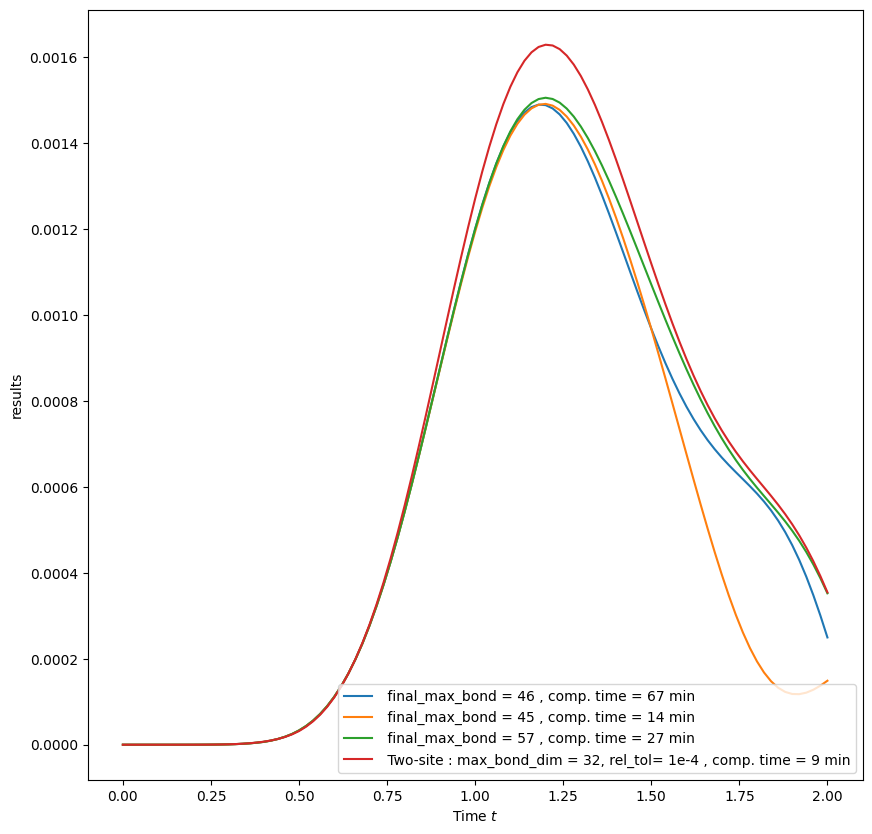

In [ ]:
fig1, axs1 = plt.subplots(1, 1, sharex=True, figsize=(10,10))


axs1.plot(times,  load_list("3_1") , label=' final_max_bond = 46 , comp. time = 67 min')
axs1.plot(times,  load_list("3_2") , label=' final_max_bond = 45 , comp. time = 14 min')
axs1.plot(times,  load_list("3_3") , label=' final_max_bond = 57 , comp. time = 27 min')
axs1.plot(times,  tdvp_results_ex1 , label=' Two-site : max_bond_dim = 32, rel_tol= 1e-4 , comp. time = 9 min')





axs1.set_xlabel("Time $t$")
axs1.set_ylabel("results")  
axs1.legend()

In [ ]:
tdvp_twosite = ptn.SecondOrderTwoSiteTDVP(initial_state = ttn1,
                                    hamiltonian = ttno,
                                    time_step_size = 0.01,
                                    final_time = 2,
                                    operators = tp,
                                    truncation_parameters= ptn.SVDParameters(max_bond_dim= 32, rel_tol= 1e-5, total_tol= -np.inf),
                                    config = None)

In [ ]:
tdvp_twosite.run(evaluation_time=2)

times = tdvp_twosite.times()
tdvp_twosite_results2 = tdvp_twosite.operator_results(realise= True)[0]

In [ ]:
save_list (tdvp_twosite_results2 , "3_3")

List saved to results/3_2


In [ ]:
for id in tdvp_twosite.state.tensors:
    print(id , tdvp_twosite.state.tensors[id].shape)

Site(1,3) (2, 2)
Site(1,2) (4, 2, 2)
Site(0,3) (2, 2)
Site(0,2) (16, 4, 2, 2)
Site(1,1) (2, 2)
Site(0,1) (18, 16, 2, 2)
Site(0,0) (17, 18, 2)
Site(1,0) (17, 16, 2)
Site(3,0) (2, 2)
Site(2,0) (16, 16, 2, 2)
Site(2,1) (16, 16, 2)
Site(3,1) (16, 15, 2)
Site(3,3) (2, 2)
Site(3,2) (15, 4, 2, 2)
Site(2,2) (4, 2, 2)
Site(2,3) (2, 2)


In [ ]:
ttn_ex = ptn.expand_subspace(tdvp_ex1.state, ttno, 3 ,
                                1e-2, ptn.SVDParameters(max_bond_dim= np.inf, rel_tol= -np.inf , total_tol= -np.inf) ,
                                tol = 1e-20, 
                                mode = ptn.KrylovBasisMode.apply_1st_order_expansion)
ttn_ex.canonical_form("Site(0,3)", ptn.SplitMode.KEEP)
ttn_ex.normalize_ttn()

for id in ttn_ex.tensors:
    print(id , ttn_ex.tensors[id].shape)

tdvp_ex1.state = ttn_ex
tdvp_ex1._orthogonalize_init()
tdvp_ex1._init_partial_tree_cache()    

tdvp_ex1.run(evaluation_time=2)
tdvp_results_ex1 = np.append( tdvp_results_ex1, tdvp_ex1.operator_results(realise=True)[0])